# Прогноз оттока клиентов

Прогнозирование оттока пользователей является важным инструментом для бизнеса, который заинтересован в удержании своих клиентов и увеличении дохода. Отток клиентов – это когда они прекращают использовать продукты или услуги компании. Это может привести к снижению дохода и необходимости заменять утерянных клиентов новыми, что требует времени и ресурсов.

Прогнозирование оттока пользователей помогает предсказать, кто из клиентов вероятнее всего покинет компанию, используя анализ данных о их поведении, а также может помочь компаниям лучше понимать причины оттока, что позволит им улучшить свои продукты или услуги, устранить технические проблемы или выработать более эффективные программы удержания клиентов.

Цель проекта - разработать модель прогнозирования оттока клиентов с метрикой ROC-AUC не меньше 0.85 за неделю

Ход проекта:
- Разведывательный анализ данных;
- Соединение таблиц(возможно создание новых признаков);
- Тестирование разных моделей и выбор лучшей.


Описание данных:
Таблица contract:
- customerID - id клиента;
- BeginDate - дата подписания договора;
- EndDate - дата расторжения договора;
- Type - тип оплаты;
- PaperlessBilling - безналичный расчет;
- PaymentMethod - метод оплаты;
- MonthlyCharges - ежемесячный платеж;
- TotalCharges - общая сумма платежей.

Таблица internet:
- customerID - id клиента;
- InternetService - тип подключения интернета;
- OnlineSecurity - подлючена ли блокировака небезопасных сайтов;
- OnlineBackup - подключено ли облачное хранилище;
- DeviceProtection - подключен ли антивирус;
- TechSupport - подключена ли выделенная линия технической поддержки;
- StreamingTV - подключено ли стриминговое телевидение;
- StreamingMovies - подключен ли каталог фильмов.

Таблица personal:
- customerID - id клиента;
- gender - пол клиента;
- SeniorCitizen - является ли клиент пенсионером;
- Partner - состоит ли клиент в браке;
- Dependents - является ли клиент иждивенцем.

Таблица phone:
- customerID - id клиента;
- MultipleLines - подключено ли несколько телефонных линий.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import phik

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

plt.rcParams["figure.figsize"] = 12, 7
sns.set(font_scale=1.2)
SEED = 270123

In [2]:
path = '/datasets/final_provider/'
if not os.path.exists('/datasets/final_provider/'):
    path = './datasets/final_provider/'

df_contract = pd.read_csv(path + 'contract.csv')
df_internet = pd.read_csv(path + 'internet.csv')
df_personal = pd.read_csv(path + 'personal.csv')
df_phone = pd.read_csv(path + 'phone.csv')

In [3]:
ProfileReport(df_contract, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

В таблице contract все значения в порядке, кроме пустый значений в TotalCharges

In [4]:
df_contract[df_contract['TotalCharges'].str.strip() == ""]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [5]:
df_contract[(df_contract['Type'] == 'Two year') & (df_contract['BeginDate'].str.contains('2020'))]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
2828,8559-WNQZS,2020-01-01,No,Two year,No,Mailed check,20.45,20.45
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5987,1099-GODLO,2020-01-01,No,Two year,No,Mailed check,20.35,20.35


Пустые значения в TotalCharges связаны с тем, что еще не было платежей, заменим их нулями.

In [6]:
df_contract.loc[df_contract['TotalCharges'].str.strip() == "", 'TotalCharges'] = 0

In [7]:
df_contract['TotalCharges'].value_counts()

0         11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [8]:
ProfileReport(df_internet, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

В таблице internet нет никаких проблем.

In [9]:
ProfileReport(df_personal, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

В таблице personal так же нет никаких проблем.

In [10]:
df_phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

В таблице phone так же нет никаких проблем.

**Предварительный план работ:**
- загрузка данных;
- первичный анализ;
- предобработка;
- объединение таблиц;
- разведочный анализ;
- моделирование;
- тестирование;
- подготовка отчета.

Соеденим таблицы и приведем признаки к нужному типу

In [11]:
df = df_contract.copy()
df = df.merge(df_internet,how='left')
df = df.merge(df_personal,how='left')
df = df.merge(df_phone,how='left')

# создаем целевой признак
df['churn'] = df['EndDate'] != 'No'
# заполним пропуски для людей которые не пользуются интернетом или телефоном
df['MultipleLines'] = df['MultipleLines'].fillna('No phone')
df = df.fillna('No internet')

In [12]:
df = df.replace('Yes', True)
df = df.replace('No', False)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(bool)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

Создадим новые признаки - количество лет от момента подключения и количество месяцев от момента подключения

In [13]:
df['total_years'] = \
        (pd.to_datetime(df['EndDate'].replace(False, '2020-02-01 00:00:00')) - df['BeginDate'])\
         // np.timedelta64(1, 'Y')

df['total_month'] = \
        (pd.to_datetime(df['EndDate'].replace(False, '2020-02-01 00:00:00')) - df['BeginDate'])\
         // np.timedelta64(1, 'M')

df['total_days'] = \
        (pd.to_datetime(df['EndDate'].replace(False, '2020-02-01 00:00:00')) - df['BeginDate'])\
         // np.timedelta64(1, 'D')

df.drop('EndDate', axis=1, inplace=True)

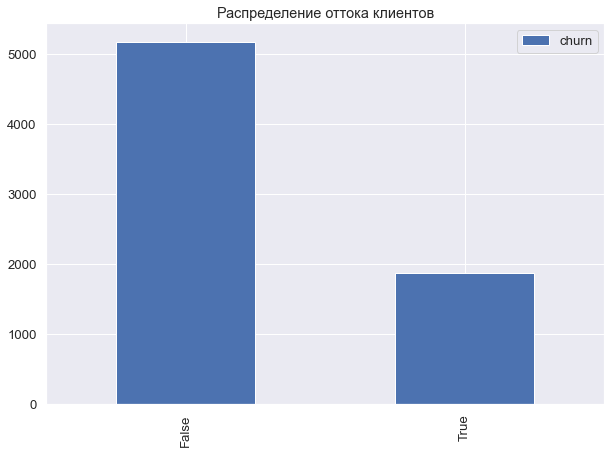

In [14]:
plt.figure(figsize=(10, 7))
df.churn.value_counts().plot(kind='bar', label='churn')
plt.legend()
plt.title('Распределение оттока клиентов')
plt.show()

Можно заметить явный дисбаланс классов, но так как метрика модели ROC-AUC - избавляться от дисбаланса не будем.

In [15]:
# создаем список категориальных признаков
category_feat = []
for col in df.columns:
    if df[col].dtype == 'object' and col != 'customerID':
        category_feat.append(col)

# создаем список бинарных признаков
binary_feat = []
for col in df.columns:
    if df[col].dtype == 'bool' and col != 'churn':
        binary_feat.append(col)

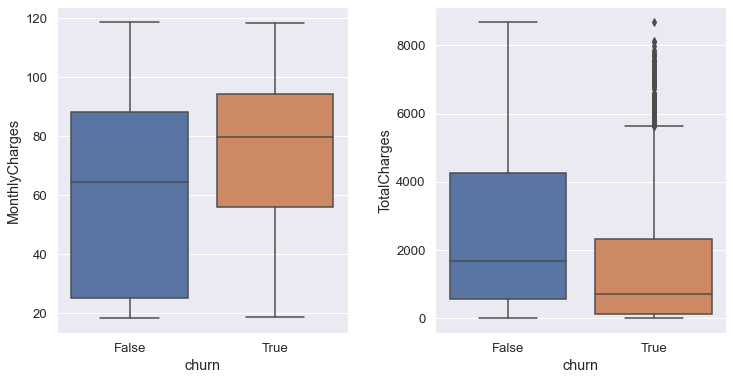

In [16]:
fig, axis = plt.subplots(1, 2, sharey=False, figsize=(12, 6))
fig.subplots_adjust(wspace=0.3)
sns.boxplot(data=df, x='churn', y='MonthlyCharges', ax=axis[0])
sns.boxplot(data=df, x='churn', y='TotalCharges', ax=axis[1])
plt.show()

Можно заметить что основной отток составляют клиенты с большей абонентской платой за месяц

Рассмотрим связь признаков с целевой переменной - оттоком клиентов. Начнем с бинарных признаков.

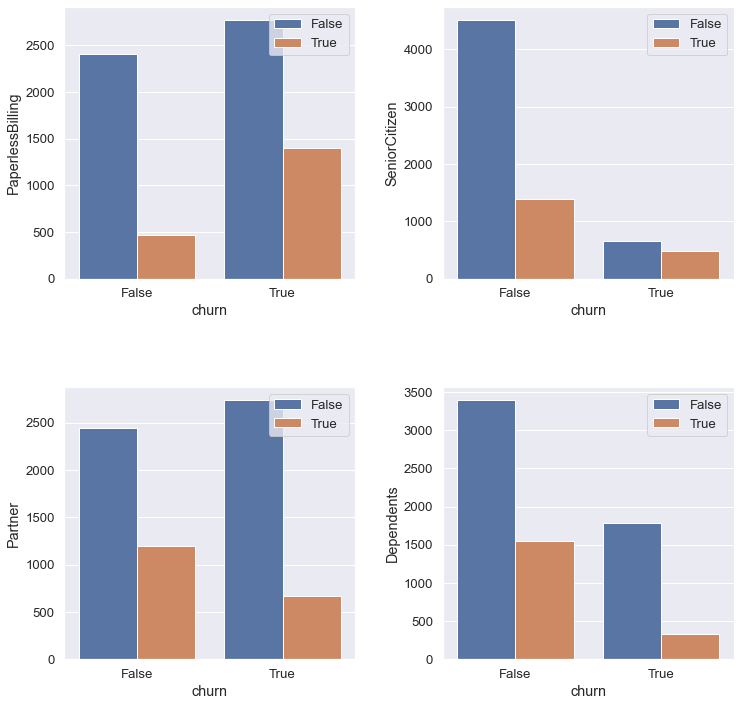

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for ax, col in zip(axes.ravel(), binary_feat):
    sns.countplot(data=df, x=col, hue='churn', ax=ax)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    ax.legend()
    ax.set_xlabel('churn')
    ax.set_ylabel(col)

- Доля оттока у тех кто пользуется безналичным расчетом намного выше;
- Очень высокая доля оттока пенсионеров;
- Выше доля оттока у людей не состоящих в браке;
- Доля оттока среди людей не являющихся иждивенцами выше.

Рассмотрим связь между целевой переменной и категориальными признаками.

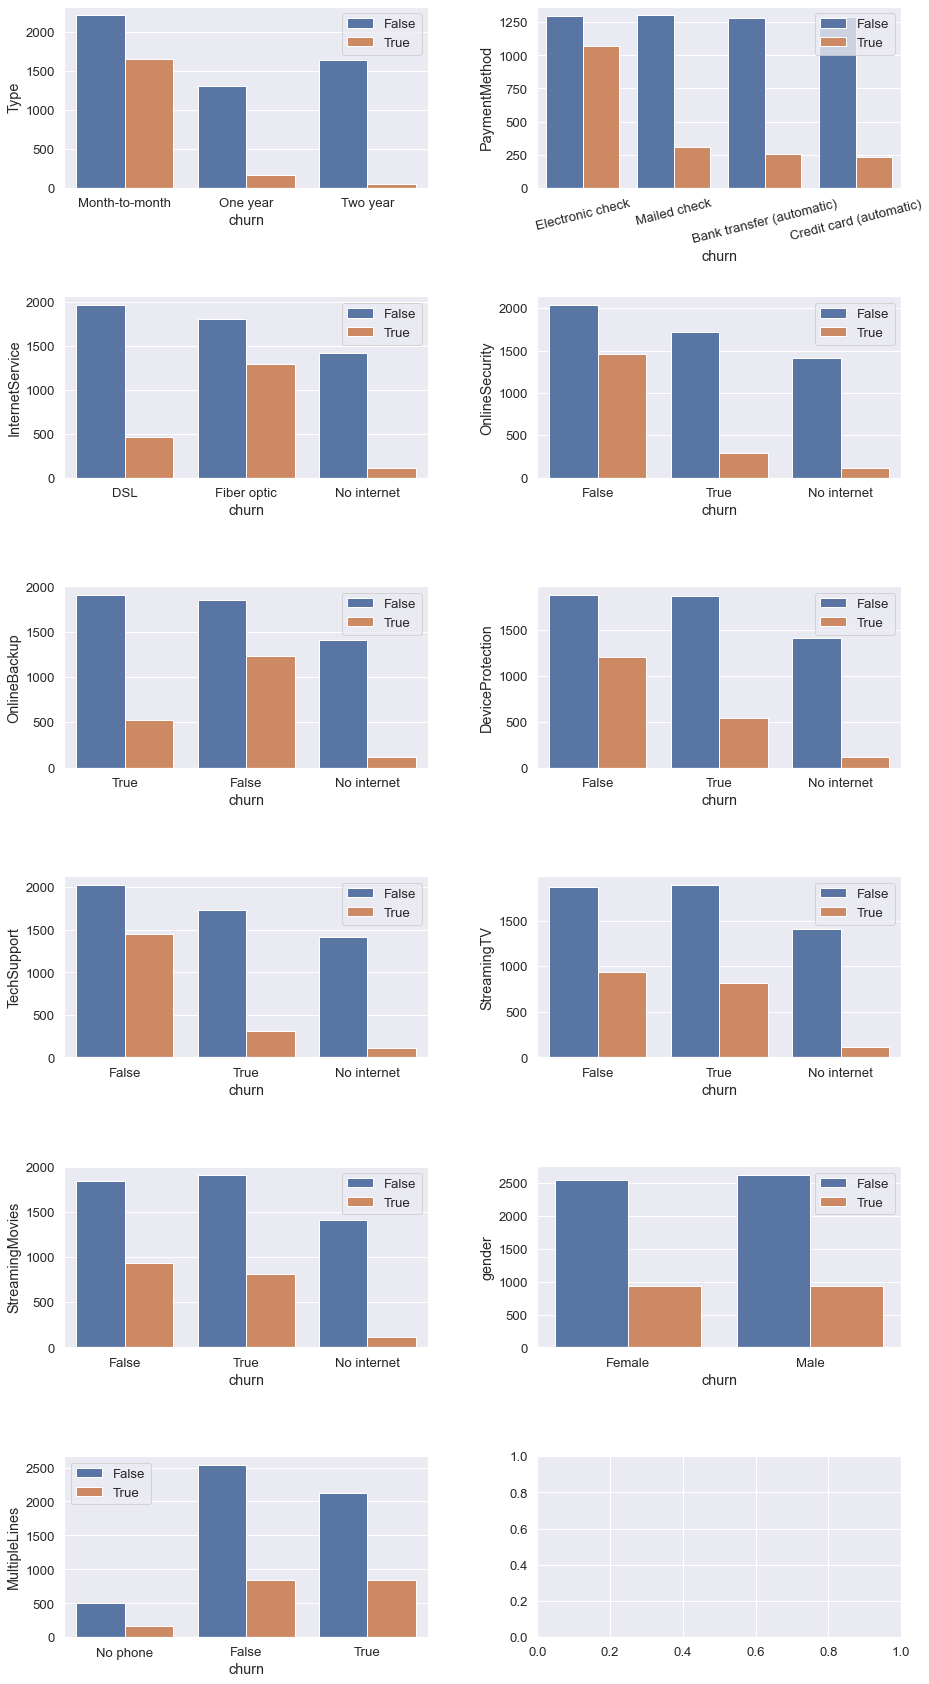

In [18]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 30))

for ax, col in zip(axes.ravel(), category_feat):
    sns.countplot(data=df, x=col, hue='churn', ax=ax)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    ax.legend()
    ax.set_xlabel('churn')
    ax.set_ylabel(col)
    if df[col].nunique() > 3:        
        ax.tick_params(axis='x', rotation=14)

- Можно заметить что большой отток приходится на людей использующих оплату по месяцам;
- Так же большой отток среди людей использующих метод оплаты Electronic check;
- Так же доля оттока выше у тех кто не использует дополнительные услуги(OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport);
- Большой отток среди людей использующих подключение по оптоволоконному кабелю.

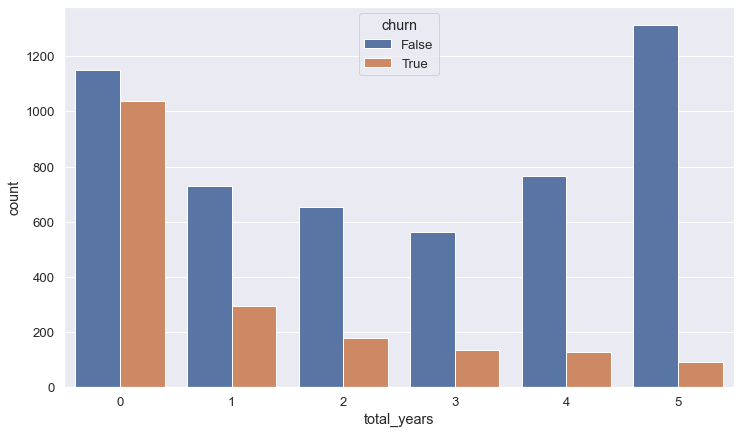

In [19]:
sns.countplot(data=df, x='total_years', hue='churn')
plt.show()

Можно заметить большую долю оттока среди новых пользователей

Посмотрим на отток по дням

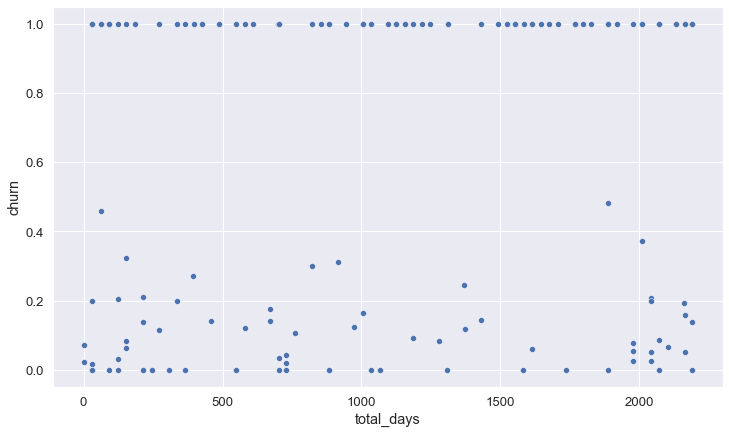

In [20]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x=df['total_days'], y=df.groupby('total_days')['churn'].mean())
plt.show()

In [21]:
churn_by_days = df.groupby('total_days')[['churn']].agg(['mean', 'count'])
churn_by_days.columns=['mean', 'count']
churn_by_days.query('mean == 1 and count > 15')

,mean,count
total_days,,
30,1.0,182
61,1.0,123
91,1.0,31
122,1.0,58
214,1.0,51
273,1.0,31
304,1.0,25
334,1.0,23
395,1.0,24


В выборке присутствует много дней с большим количеством оттока, но только в части этих дней количество пользователей превышало 15. Стоит обратить внимание на 30, 61, 91 и 122 дни, возможно для новых пользователей действовала акция, а после её окончания они расторгали договор.

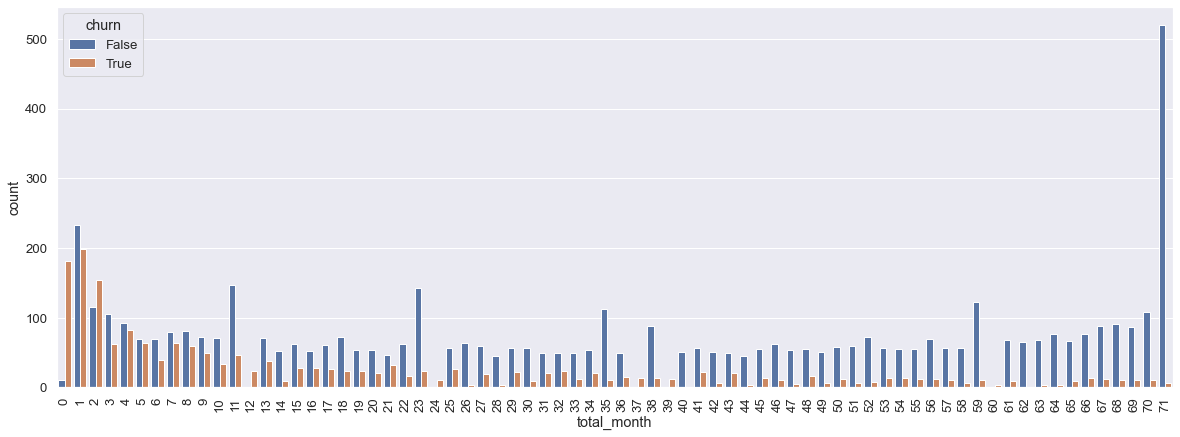

In [22]:
plt.figure(figsize=(20, 7))
sns.countplot(data=df, x='total_month', hue='churn')
plt.xticks(rotation=90)
plt.show()

Распределение оттока по месяцам подтверждает предыдущие вывод - среди новых пользователей большая доля оттока.

Создадим новые признаки

In [23]:
# Разделим на сегменты по медиане MonthlyCharges и количеству лет
divider = df['MonthlyCharges'].median()
for year in df['total_years'].unique():
    df.loc[(df['total_years'] == year) & (df['MonthlyCharges'] <= divider), 'segmentation_m'] = f'{year} years low'
    df.loc[(df['total_years'] == year) & (df['MonthlyCharges'] > divider), 'segmentation_m'] = f'{year} years high'
    
df['segmentation_m'].isna().sum()

0

In [24]:
# Разделим на сегменты по медиане TotalCharges и количеству лет
divider = df['TotalCharges'].median()
for year in df['total_years'].unique():
    df.loc[(df['total_years'] == year) & (df['TotalCharges'] <= divider), 'segmentation'] = f'{year} years low'
    df.loc[(df['total_years'] == year) & (df['TotalCharges'] > divider), 'segmentation'] = f'{year} years high'
    
df['segmentation'].isna().sum()

0

In [25]:
# Количество сервисов
services = binary_feat.copy()
services.remove('PaperlessBilling')
services.remove('Partner')
services.remove('SeniorCitizen')
services.remove('Dependents')

df['service_count'] = df[services].sum(axis=1) + (df['InternetService'] != 'No internet')


In [26]:
# Является ли пенсионером и подписан ли договор за последние 3 года
df.loc[(df['total_years'] <= 3) & (df['SeniorCitizen'] == True), 'new_and_senior'] = 1
df['new_and_senior'].fillna(0, inplace=True)

In [27]:
# использует все стриминговые сервисы
df['using_all_streaming'] = (df[['StreamingTV', 'StreamingMovies']] == 1).sum(axis=1) > 0

In [28]:
# помесячная оплата за каждый сервис
df['monthly_per_service'] = df['MonthlyCharges'] / df['service_count']
# отношение месячной оплаты за каждый сервис к месячной плате 
df['per_service_to_monthly'] = df['monthly_per_service'] / df['MonthlyCharges']
df.replace([np.inf, -np.inf], 0, inplace=True)

In [29]:
# Тип оплаты month-to-month по полу
df.loc[(df['gender'] == 'Female') & (df['Type'] == 'Month-to-month'), 'mtm_gender'] = 'female_mtm'
df.loc[(df['gender'] == 'Male') & (df['Type'] == 'Month-to-month'), 'mtm_gender'] = 'male_mtm'
# Метод оплаты electronic check по полу 
df.loc[(df['gender'] == 'Female') & (df['PaymentMethod'] == 'Electronic check'), 'el_check_gender'] = 'female_mtm'
df.loc[(df['gender'] == 'Male') & (df['PaymentMethod'] == 'Electronic check'), 'el_check_gender'] = 'male_mtm'
df.fillna('None', inplace=True)

df.loc[(df['Type'] == 'Month-to-month') & (df['PaymentMethod'] == 'Electronic check'), 'mtm_ec'] = 1
df.fillna(0, inplace=True)

In [30]:
# Разбиваем признаки по полу
def sep_by_gender(df, col):
    for val in df[col].unique():
        df.loc[(df['gender'] == 'Male') & (df[col] == val), f'{col}_by_gender'] = f'{val}_Male'   
        df.loc[(df['gender'] == 'Female') & (df[col] == val), f'{col}_by_gender'] = f'{val}_Female'       

sep_by_gender(df, 'SeniorCitizen')
sep_by_gender(df, 'Partner')
sep_by_gender(df, 'MultipleLines')
sep_by_gender(df, 'Dependents')

In [31]:
# Оптоволокно + нет TechSupport по полу
df.loc[(df['TechSupport'] == False) & (df['gender'] == 'Male') \
       & (df['InternetService'] == 'Fiber optic'), 'fiber_no_tech_by_gender'] = 'male'
df.loc[(df['TechSupport'] == False) & (df['gender'] == 'Female') \
       & (df['InternetService'] == 'Fiber optic'), 'fiber_no_tech_by_gender'] = 'female'

df['fiber_no_tech_by_gender'] = df['fiber_no_tech_by_gender'].fillna('None')

Посмотрим на корреляцию признаков.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'total_years', 'total_month', 'total_days', 'service_count', 'new_and_senior', 'monthly_per_service', 'per_service_to_monthly', 'mtm_ec']


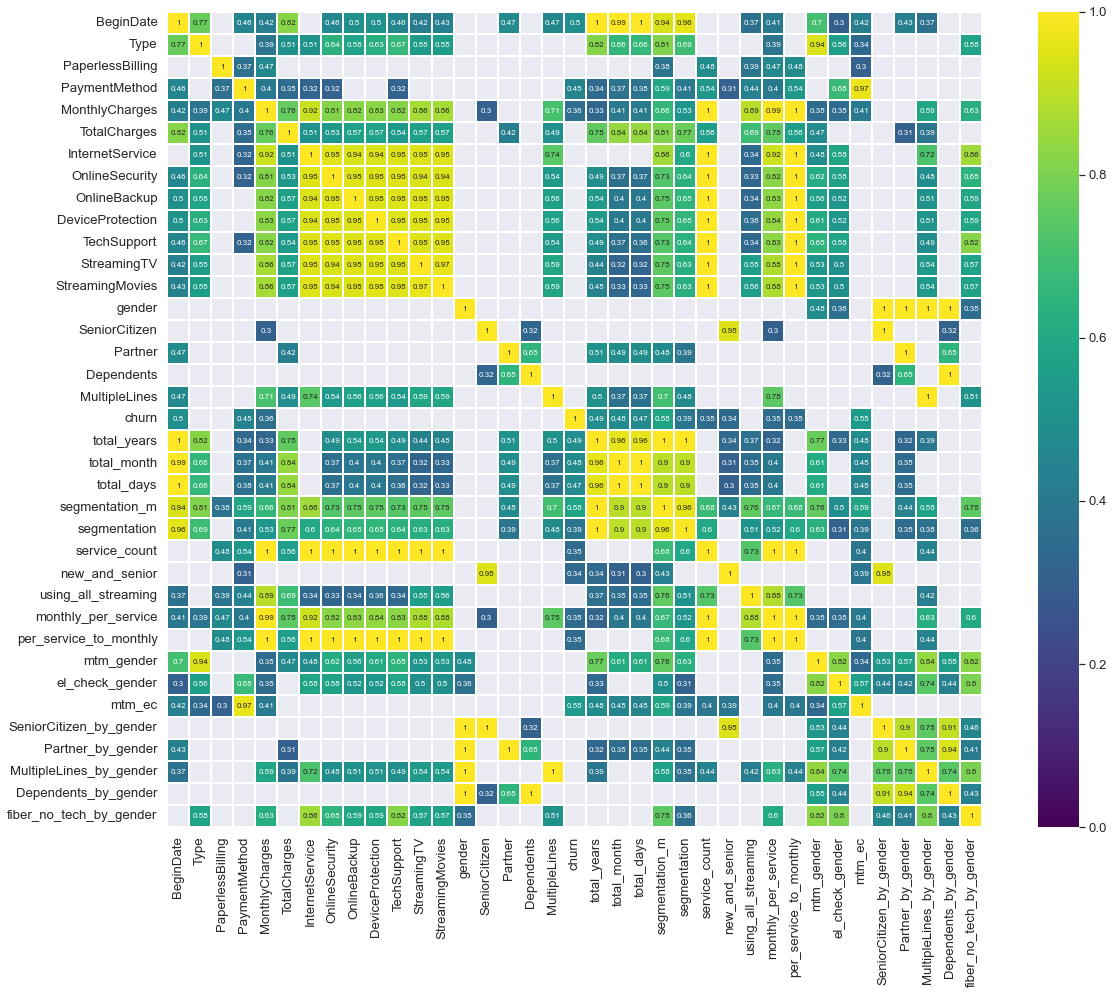

In [32]:
corr = df.drop('customerID', axis=1).phik_matrix()

plt.figure(figsize=(20, 15))
sns.heatmap(corr[(corr >= 0.3)],
            cmap='viridis', vmax=1.0, vmin=0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

plt.show()

У целевой переменной есть небольшая корреляция с некоторыми признаками, так же присутствует много коррелирующих друг с другом признаков. С мультиколлинеарностью ничего делать не будем, так как будем использовать модели с регуляризацией.

## Проверка моделей

Удалим ненужные признаки для обучения модели.

In [33]:
df.drop(['customerID', 'BeginDate'], axis=1, inplace=True)

In [34]:
# создаем список категориальных признаков
cat_features = df.select_dtypes(include='object').columns.to_list()       
cat_features

['Type',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'gender',
 'MultipleLines',
 'segmentation_m',
 'segmentation',
 'mtm_gender',
 'el_check_gender',
 'SeniorCitizen_by_gender',
 'Partner_by_gender',
 'MultipleLines_by_gender',
 'Dependents_by_gender',
 'fiber_no_tech_by_gender']

Разобьем данные на train и test

In [35]:
df['churn'] = df['churn'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
        df.drop('churn', axis=1), df['churn'], test_size=.25,
        stratify=df['churn'], random_state=SEED)

In [36]:
# создаем DataFrame для хранения информации о моделях
model_info = pd.DataFrame()

### Линейные модели

Закодируем категориальные признаки методом OHE

In [37]:
binary_feat = df.select_dtypes(include='bool').columns.to_list()
X_train_ohe = X_train.copy()

# Заменим бинарные значения в категориальных признаках
X_train_ohe[cat_features] = X_train_ohe[cat_features].replace(True, 'True')
X_train_ohe[cat_features] = X_train_ohe[cat_features].replace(False, 'False')

X_train_ohe[binary_feat] = X_train_ohe[binary_feat].astype(int)
cat_features

['Type',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'gender',
 'MultipleLines',
 'segmentation_m',
 'segmentation',
 'mtm_gender',
 'el_check_gender',
 'SeniorCitizen_by_gender',
 'Partner_by_gender',
 'MultipleLines_by_gender',
 'Dependents_by_gender',
 'fiber_no_tech_by_gender']

In [38]:
num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns.to_list()
num_feat

['MonthlyCharges',
 'TotalCharges',
 'total_years',
 'total_month',
 'total_days',
 'service_count',
 'new_and_senior',
 'monthly_per_service',
 'per_service_to_monthly',
 'mtm_ec']

In [39]:
num_feat.remove('service_count')
num_feat.remove('new_and_senior')
num_feat.remove('mtm_ec')
num_feat.remove('per_service_to_monthly')

In [40]:
col_trans = ColumnTransformer(transformers=[
    ('cat_pipe', OneHotEncoder(drop='first', sparse_output=False), cat_features),
    ('num_pipe', StandardScaler(), num_feat)
])
pipe = Pipeline(steps=[
    ('col_trans', col_trans),
    ('clf', LogisticRegression(random_state=SEED))
])

In [41]:
params = {
    'clf__C': [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1., 1.5, 1.6, 2, 2.5],
    'clf__penalty': ['l2'],
    'clf__solver': ['liblinear']
}
clf = GridSearchCV(
    pipe,
    params, scoring='roc_auc')
clf.fit(X_train_ohe, y_train)

model_info['Логистическая регрессия'] = (clf.best_score_, clf.best_params_)

Так же проверим линейную модель с PCA.

In [42]:
# One hot encoding
encoder = OneHotEncoder(drop='first' , sparse_output=False)
encoder.fit(X_train_ohe[cat_features])

OneHotEncoder(drop='first', sparse_output=False)

In [43]:
X_train_ohe[encoder.get_feature_names_out()] = encoder.transform(X_train_ohe[cat_features])
X_train_ohe = X_train_ohe.drop(cat_features, axis=1)

In [44]:
pca = PCA(n_components=50)
pca.fit(X_train_ohe)
pca_feat = pca.transform(X_train_ohe)

In [45]:
params = {
    'C': [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1., 1.5, 1.6, 2, 2.5],
    'penalty': ['l1', 'l2'],    
    'solver': ['liblinear']
}
clf = GridSearchCV(
    LogisticRegression(solver='liblinear', random_state=SEED),
    params, scoring='roc_auc')
clf.fit(pca_feat, y_train)

model_info['Логистическая регрессия + PCA'] = (clf.best_score_, clf.best_params_)

### Бустинги

Добавим к сравнению CatBoostClassifier и LGBMClassifier

In [46]:
X_train_boost = X_train.copy()
X_train_boost[cat_features] = X_train_boost[cat_features].astype('category')

In [47]:
# def objective(trial, features=X_train_boost, target=y_train):
#     '''Подбираем гиперпараметры lgbm через Optuna'''
#     param_grid = {
#         'boosting_type': trial.suggest_categorical("boosting_type", ['rf', 'gbdt', 'dart']),
#         "n_estimators": trial.suggest_int('n_estimators', 1000, 8000),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 1),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
#         "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#         "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#         "bagging_fraction": trial.suggest_float(
#             "bagging_fraction", 0.2, 0.95, step=0.1
#         ),
#         "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
#         "feature_fraction": trial.suggest_float(
#             "feature_fraction", 0.2, 0.95, step=0.1
#         ),
#     }

#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

#     cv_scores = np.empty(5)
#     for idx, (train_idx, test_idx) in enumerate(cv.split(features, target)):
#         X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
#         y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
#         model = LGBMClassifier(**param_grid)
#         model.fit(
#             X_train,
#             y_train,
#             #is_unbalance=True,
#             eval_set=[(X_test, y_test)],
#             eval_metric='AUC',
#             early_stopping_rounds=200,
#             categorical_feature=cat_features,
#             verbose=False
#         )
#         preds = model.predict_proba(X_test)[:, 1]
#         cv_scores[idx] = roc_auc_score(y_test, preds)

#     return np.mean(cv_scores)

# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective, n_trials = 50)
# print('Best value:', study.best_value)

In [48]:
# Лучшие гиперпараметры и лучший скор
lgbm_params = {'boosting_type': 'gbdt',
 'n_estimators': 4890,
 'learning_rate': 0.43455236390638036,
 'num_leaves': 640,
 'max_depth': 9,
 'min_data_in_leaf': 200,
 'lambda_l1': 10,
 'lambda_l2': 75,
 'min_gain_to_split': 3.327368612613349,
 'bagging_fraction': 0.30000000000000004,
 'bagging_freq': 1,
 'feature_fraction': 0.6000000000000001}

model_info['lgbm'] = (0.8422258748080441, lgbm_params)

In [49]:
# def objective(trial, features=X_train_boost, target=y_train):
#     '''Подбираем гиперпараметры CatBoost через Optuna'''
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1, 0.3]),
#         'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
#         'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 3.0, log = True),
#         'subsample': trial.suggest_float('subsample', 0.1, 0.8),
#         'random_state': SEED,
#         'loss_function': 'Logloss',
#         'eval_metric': 'AUC',
#     }
    
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
#     cv_scores = np.empty(5)
#     for idx, (train_idx, test_idx) in enumerate(cv.split(features, target)):
#         X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
#         y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

#         model = CatBoostClassifier(**params)  
#         model.fit(
#             X_train, y_train, 
#             eval_set=[(X_test, y_test)], 
#             cat_features=cat_features,
#             early_stopping_rounds=200, 
#             verbose = False
#         )
#         preds = model.predict_proba(X_test)[:, 1]
#         cv_scores[idx] = roc_auc_score(y_test, preds)

#     return np.mean(cv_scores)


# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective, n_trials = 50)
# print('Best value:', study.best_value)

In [50]:
# Лучшие гиперпараметры и лучший скор
cat_params = {'max_depth': 3,
 'learning_rate': 0.08,
 'n_estimators': 6322,
 'max_bin': 380,
 'min_data_in_leaf': 64,
 'l2_leaf_reg': 0.001523491536683995,
 'subsample': 0.4864386981750388}

model_info['cat'] = (0.9175541014365904, cat_params)

## Выбор лучшей модели

In [51]:
model_info.index = ['roc-auc', 'Лучшие гиперпараметры']

model_info

,Логистическая регрессия,Логистическая регрессия + PCA,lgbm,cat
roc-auc,0.857742,0.884182,0.842226,0.917554
Лучшие гиперпараметры,"{'clf__C': 2.5, 'clf__penalty': 'l2', 'clf__so...","{'C': 1.0, 'penalty': 'l2', 'solver': 'libline...","{'boosting_type': 'gbdt', 'n_estimators': 4890...","{'max_depth': 3, 'learning_rate': 0.08, 'n_est..."


Лучшей моделью оказался CatBoostClassifier

## Отбор признаков

Выберем лучшие признаки основываясь на feature_importances лучшей модели

In [52]:
def get_cv_auc(features, target):
    '''Возвращает средний auc-roc с использованием кросс-валидации'''
    cat_features = features.select_dtypes(include='category').columns.to_list()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(features, target)):
        X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
        y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

        model = CatBoostClassifier(**cat_params)  
        model.fit(
            X_train, y_train, 
            cat_features=cat_features,
            verbose = False
        )
        preds = model.predict_proba(X_test)[:, 1]
        cv_scores[idx] = roc_auc_score(y_test, preds)
        
    return np.mean(cv_scores)

Посмотрим на влияние признаков модели обученной на всех признаках

In [53]:
clf = CatBoostClassifier(**cat_params, random_state=SEED, cat_features=cat_features, verbose=False)
clf.fit(X_train_boost, y_train)

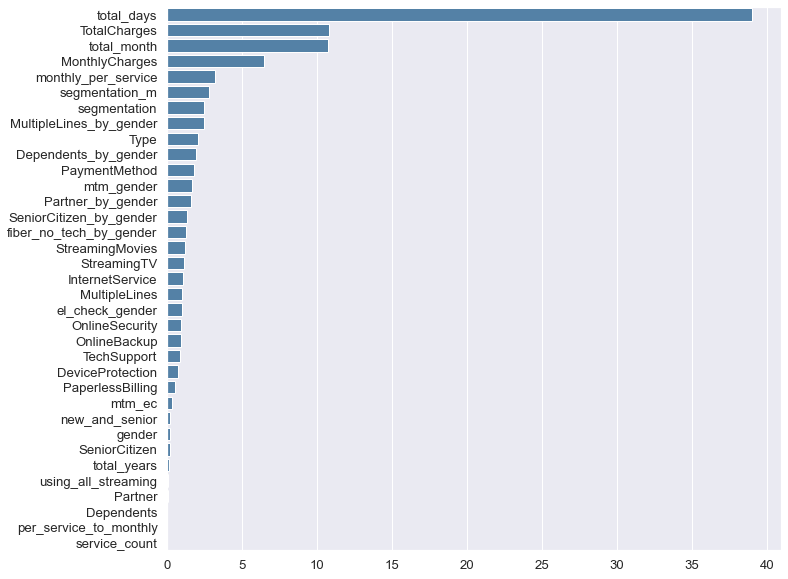

In [54]:
fi = pd.Series(clf.feature_importances_, X_test.columns).sort_values(ascending=False)
plt.figure(figsize=(11, 10))
sns.barplot(x=fi, y=fi.index, color='steelblue')
plt.show()

In [55]:
get_cv_auc(X_train_boost, y_train)

0.915476795934465

Сравним auc-roc с моделью обученной на наиболее информативных признаках

In [56]:
tf = fi[fi > 2].index
get_cv_auc(X_train_boost[tf], y_train)

0.9187141261877683

In [57]:
X_train_boost = X_train_boost[tf]
X_test = X_test[tf]
tf

Index(['total_days', 'TotalCharges', 'total_month', 'MonthlyCharges',
       'monthly_per_service', 'segmentation_m', 'segmentation',
       'MultipleLines_by_gender', 'Type'],
      dtype='object')

Нам удалось избавится от неинформативных признаков и немного повысить метрику

## Тестирование лучшей модели

Протестируем CatBoost на тестовой выборке

In [58]:
cat_features = X_train_boost.select_dtypes(include='category').columns.to_list()

In [59]:
clf = CatBoostClassifier(**cat_params, random_state=SEED, cat_features=cat_features, verbose=False)
clf.fit(X_train_boost, y_train)

In [60]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.9207791520077843

Roc auc на тестовой выборке равен 0.9207791520077843

Посмотрим на матрицу ошибок

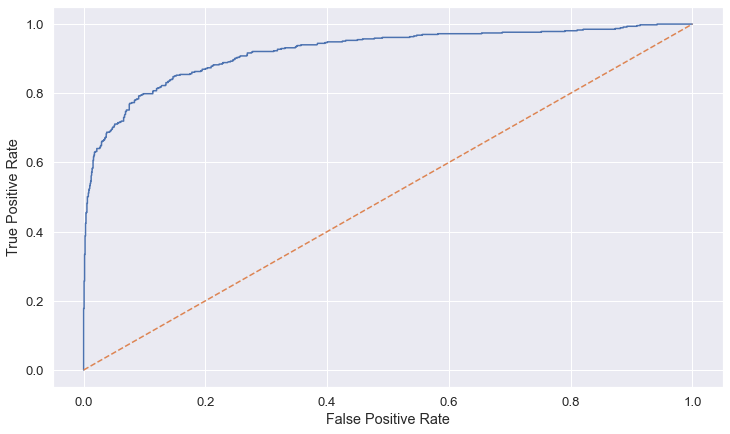

In [61]:
fig, ax = plt.subplots()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1]) 
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()

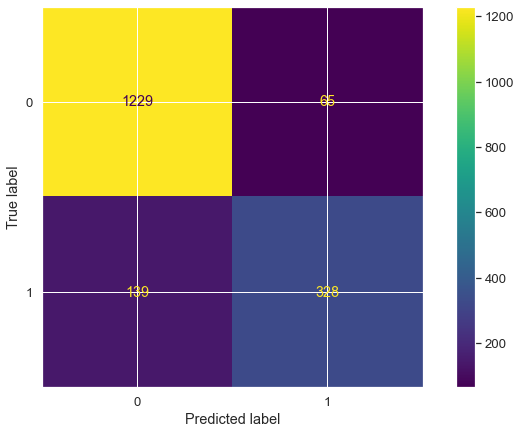

In [62]:
cm = confusion_matrix(y_test, clf.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

Матрица ошибок показывает 65 False Positive и 139 False Negative ошибок. То есть для 65 человек модель предсказала что они уйдут, а они остались, а для 139 людей модель предсказала то что они останутся, а они ушли.

Для бизнеса важнее те 139 человек, которые ушли, а по предсказаниям должны были остаться, ведь лучше потратить чуть больше денег на акции для этих людей, чем вовсе их потерять. Соответственно можно настроить модель, чтобы она захватывала большее количество людей(и тех что хотели уйти, и тех что в любом случае бы остались), в этом случае повысятся затраты на акции(они будут предлагаться и людям, которые остались бы в любом случае), но получится предсказать большее число людей, которые ушли бы на самом деле, а значит и уменьшить отток клиентов.

Посмотрим на влияние признаков

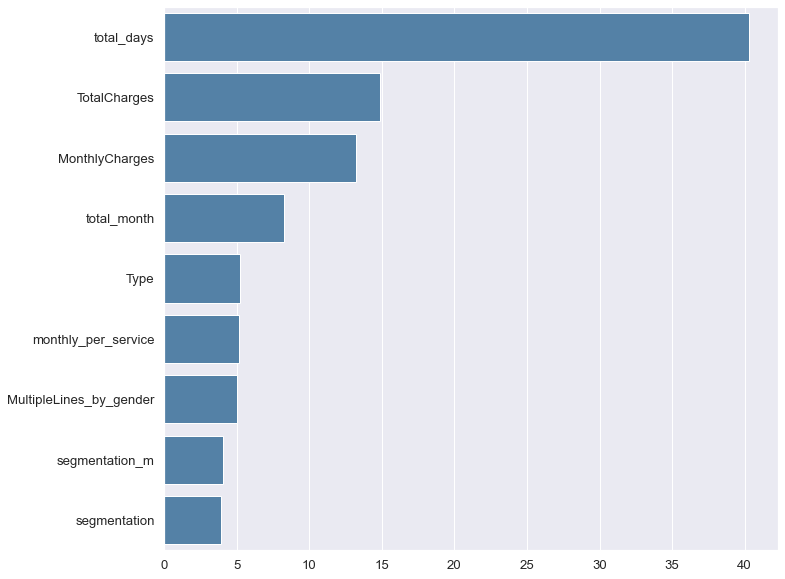

In [63]:
fi = pd.Series(clf.feature_importances_, X_test.columns).sort_values(ascending=False)
plt.figure(figsize=(11, 10))
sns.barplot(x=fi, y=fi.index, color='steelblue')
plt.show()

Рассмотрим наиболее значимые признаки выделенные моделью. total_days и total_month - большая доля оттока в определенные дни может быть связана с концом акционных предложений, так же большая доля оттока в первые месяцы после заключения договора. TotalCharges, MonthlyCharges, monthly_per_service - возможно пользователи недовольны ценами на услуги.

## Отчет
### Введение
Прогнозирование оттока пользователей является важным инструментом для бизнеса, который заинтересован в удержании своих клиентов и увеличении дохода. Отток клиентов – это когда они прекращают использовать продукты или услуги компании. Это может привести к снижению дохода и необходимости заменять утерянных клиентов новыми, что требует времени и ресурсов.

Прогнозирование оттока пользователей помогает предсказать, кто из клиентов вероятнее всего покинет компанию, используя анализ данных о их поведении, а также может помочь компаниям лучше понимать причины оттока, что позволит им улучшить свои продукты или услуги, устранить технические проблемы или выработать более эффективные программы удержания клиентов.

Цель проекта - разработать модель прогнозирования оттока клиентов с метрикой ROC-AUC не меньше 0.85 за неделю

### Данные
Предоставлен датасет который содержит информацию о семи тысячах пользователей. В данных содержится информация о услгуах, подключенных пользователями, дате начала и окончания договора, методе оплаты, типе оплаты, размере оплаты. Так же были составлены синтетические признаки:
- количетсво лет с момента заключения договора;
- количество месяцев с момента заключения договора;
- количество дней с момента заключения договора;
- разделение на сегменты по медиане TotalCharges и количеству лет;
- разделение на сегменты по медиане MonthlyCharges и количеству лет;
- количество поключенных услуг;
- является ли пенсионером и подписан ли договор за последние 3 года;
- использует ли все стриминговые сервисы;
- помесячная оплата за каждый сервис;
- отношение месячной оплаты за каждый сервис к месячной плате;
- Тип оплаты month-to-month по полу;
- метод оплаты electronic check по полу;
- признак SeniorCitizen по полу;
- признак Partner по полу;
- признак MultipleLines по полу;
- признак Dependents по полу;
- оптоволоконный тип подключения и нет TechSupport по полу.

 ### Моделирование
 Использовались следующие алгоритмы:
 1) Логистическая регрессия. Для логистической регрессии категориальные признаки были закодированы с использованием One Hot Encoding, количественные были отмасштабированны с использованием StandardScaler;
 
 2) Логистическая регрессия и Principal component analysis (PCA). Категориальные признаки были закодированны с использованием One Hot Encoding, количественные признаки не масштабировались;
 
 3) LGBMClassifier. Были использованы встроенные методы обработки категориальных признаков, количественные признаки не масштабировались;
 
 4) CatBoostClassifier. Были использованы встроенные методы обработки категориальных признаков, количественные признаки не масштабировались.
 
 Для обучения моделей были использованы девять наиболее информативных признаков отобранных через feature_importances. Модели оценивались метрикой качетва AUC ROC посредством кросс-валидации.

### Результаты

In [64]:
with pd.option_context('display.max_colwidth', 400):
    display(model_info)

,Логистическая регрессия,Логистическая регрессия + PCA,lgbm,cat
roc-auc,0.857742,0.884182,0.842226,0.917554
Лучшие гиперпараметры,"{'clf__C': 2.5, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}","{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}","{'boosting_type': 'gbdt', 'n_estimators': 4890, 'learning_rate': 0.43455236390638036, 'num_leaves': 640, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 10, 'lambda_l2': 75, 'min_gain_to_split': 3.327368612613349, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}","{'max_depth': 3, 'learning_rate': 0.08, 'n_estimators': 6322, 'max_bin': 380, 'min_data_in_leaf': 64, 'l2_leaf_reg': 0.001523491536683995, 'subsample': 0.4864386981750388}"


Наилучшие результаты для нашего набора данных показал CatBoostClassifier с метрикой auc roc 0.917554 на тренировочной выборке с кросс-валидацией и 0.920779 на тестовой выборке.

### Выводы
Исследование было проведено в соответствии с первоначальным планом, с добавлением к нему нового пункта - разработка синтетических признаков, который помог улучшить метрику модели. Ключевыми шагами являются:
- Разведочный анализ данных;
- Разработка синтетических признаков. 

Трудность возникла с поднятием метрики, решилась генерацией синтетических признаков.

Выделяются группы пользователей с большой долей оттока: 

- новые пользователи - много клиентов уходит в первый год подключения;
- клиенты с типом подключения интернета fiber optic(подключение по оптоволоконному кабелю);
- Пенсионеры;
- клиенты которые не используют дополнительные услуги(OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport);
- клиенты с помесячным типом оплаты;
- клиенты использующие метод оплаты Electronic check;
- так же стоит уделить особое внимание той группе людей, которые расторгают договор через определенное количество дней(30, 61, 91 и так далее). Возможно для новых пользователей действует акция, по окончанию которой они уходят.


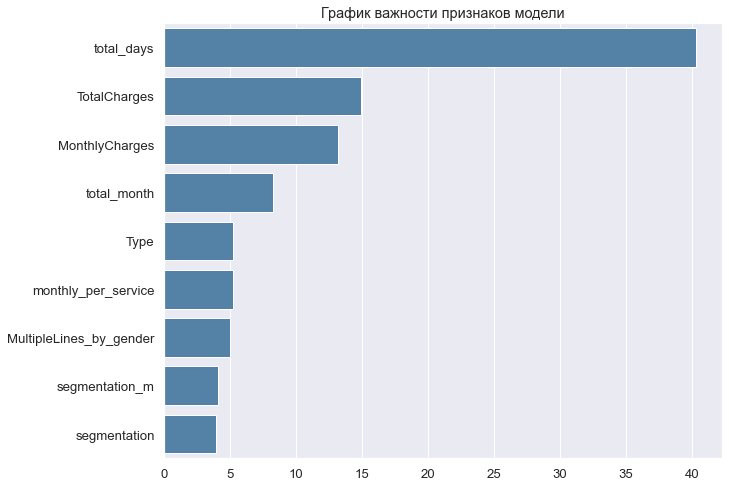

In [65]:
plt.figure(figsize=(10, 8))
sns.barplot(x=fi, y=fi.index, color='steelblue')
plt.title('График важности признаков модели')
plt.show()

Рассмотрим наиболее значимые признаки выделенные моделью. total_days и total_month - большая доля оттока в определенные дни может быть связана с концом акционных предложений, так же большая доля оттока в первые месяцы после заключения договора. TotalCharges, MonthlyCharges, monthly_per_service - возможно пользователи недовольны ценами на услуги.

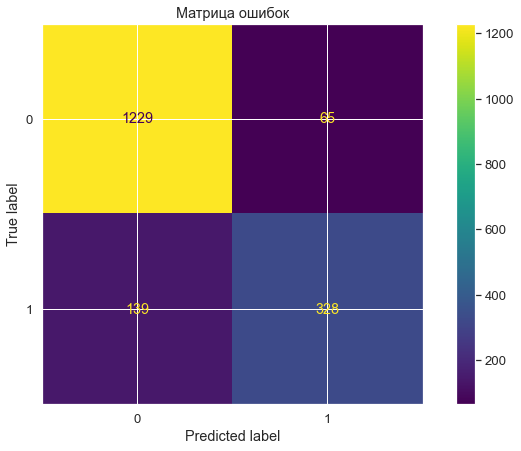

In [66]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Матрица ошибок')
plt.show()

Матрица ошибок показывает 65 False Positive и 139 False Negative ошибок. То есть для 65 человек модель предсказала что они уйдут, а они остались, а для 139 людей модель предсказала то что они останутся, а они ушли.

Ошибки False Negative для нас являются более важными(люди, которые по предсказанию модели должны были остаться, но на самом деле ушли) по причине того, что каждая такая ошибка - это ушедший от нас клиент и потерянные деньги. Модель классификации можно настроить таким образом, чтобы верно классифицировать практически каждого клиента, который собирается уйти, но при этом будет относить к этому классу больше клиентов которые не собирались уходить. Соответственно мы будем предлагать лишним клиентам(тем, что остались бы и без акционных предложений), но так же сможем удержать больше клиентов которые хотели уйти на самом деле.